# Virtual Cell model - Analysis - MD vs MC

In [9]:
#Go in the working directory

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd $workdir/

/Users/michael/Desktop/VCM_repo


In [10]:
# Import packages

import os
import json
import pandas as pd
import numpy as np
import mdtraj as md
import matplotlib as mpl, matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 100%; }
    div#maintoolbar-container { width: 100%; }
</style>
"""))

plt.rcParams.update({'font.size':16,'legend.frameon':True,'figure.figsize':[12,8],'xtick.major.size':7,'ytick.major.size':7,'legend.labelspacing':1})

# Functions

In [11]:
# Calculate the density profile of ions

Nav = 6.022e23          # 1/mol
to_mM = 1e24/Nav *1000 # convert 1/nm^3 --> mmol/l

def densityProfile(traj, I,  bins):
    ''' calculates the ion profile from trajectory '''
    d = []
    sel = traj.top.select('name '+(I)) # Ions index
    traj.atom_slice(sel, inplace=True)  # Create a new trajectory from a subset of atoms
    origin = np.array(traj.unitcell_lengths[0]/2) # Middle of box
    
    for i in traj.xyz:
        d.append(np.linalg.norm(i-origin, axis=1)) # Ions distances from the middle of the box
    d = np.array(d).flatten()  # Return a copy of the array collapsed into one dimension
    P, r = np.histogram(d, bins=bins) # Histogram of the distances
    r=r[:-1]
    dr = r[1]-r[0]
    rho = P/(4*np.pi*r**2*dr) * to_mM / len(d) * len(sel)
    return r, rho

# Solution conditions

In [14]:
####################################################
Ions = {'Cl':{ 'pH': [2], 'r':[2.4, 2.6, 2.8, 3.0]},
        'F': { 'pH': [2], 'r':[2.4, 2.6, 2.8, 3.0]}}
####################################################

##########################################################################
Cp_range = [0.001, 0.002, 0.0040, 0.0070, 0.01, 0.015, 0.02, 0.025, 0.03]#
##########################################################################

Na = 6.022e23

# Save MD density profiles

In [15]:
%cd $workdir/Molecular_dynamics

for name, prop in Ions.items():
    for pH in prop ['pH']:
        for r in prop ['r']:
            for g in range(1):
                path = str(name)+'/'+str(pH)+'/'+str(r)+'/'+str(g)+'/'
                
                if os.path.isfile(path+'density_P.rho'):
                    print('Profile already saved')
                
                else:
                    traj = md.load(path+'run.dcd', top=path+'../../Protein_'+str(name)+'.pdb')
                    r_xtc, rho_xtc = densityProfile(traj, name, 2000) # Calculate density profiles use 2000 bins
                    np.savetxt(path+'density_P.rho',np.c_[r_xtc,rho_xtc]) # Save density profiles 
                    print('Saving profile ...')

%cd $workdir

/Users/michael/Desktop/VCM_repo/Molecular_dynamics
Profile already saved
Profile already saved
Profile already saved
Profile already saved
Profile already saved
Profile already saved
Profile already saved
Profile already saved
/Users/michael/Desktop/VCM_repo


# Extract the pressure from MD simulations

In [17]:
p_osm_virtual_cell = {}
p_osm_virtual_cell_excess = {}
Cp_list = np.empty(0)
##############################

for name, prop in Ions.items():
    p_osm_virtual_cell[str(name)] = {}
    p_osm_virtual_cell_excess[str(name)] = {}
    for pH in prop ['pH']:
        for r in prop ['r']:
            for g in range(1):
                path = str(name)+'/'+str(pH)+'/'+str(r)+'/'+str(g)+'/'
                
                x, rho = np.loadtxt(workdir+'/Molecular_dynamics/'+path+'density_P.rho',unpack=True)
                rdif = np.abs(x-float(r))
                
                p_osm_virtual_cell[str(name)][r] =  rho[rdif==rdif.min()]
                V = 4/3 *np.pi * r**3
                Cp = (1/V)*1e27/Na
                if name=='Cl':
                    Cp_list = np.append(Cp_list, Cp)
                p_osm_virtual_cell_excess[str(name)][r] =  rho[rdif==rdif.min()]-7*Cp

                
p_osm_virtual_cell = pd.DataFrame(p_osm_virtual_cell)
p_osm_virtual_cell_excess = pd.DataFrame(p_osm_virtual_cell_excess)
Cp_list = np.array(Cp_list)
print(p_osm_virtual_cell)
print(p_osm_virtual_cell_excess)

                       Cl                     F
2.4  [145.64898697709944]  [133.78387359092608]
2.6  [108.71946496132556]  [100.44800290521027]
2.8   [81.09104655808306]   [78.05110972710412]
3.0   [66.95577350252137]   [64.95219930340302]
                        Cl                     F
2.4   [-55.09149123099931]  [-66.95660461717267]
2.6   [-49.16835768027413]  [-57.43981973638941]
2.8  [-45.322782284334835]  [-48.36271911531378]
3.0   [-35.82335134002517]  [-37.82692553914352]


# Load pressure from MC simulations

In [19]:
p_osm_cell = pd.read_csv('Monte_Carlo/p_osm_cell.csv')
p_osm_cell_ex = pd.read_csv('Monte_Carlo/p_osm_cell_ex.csv')

p_osm_cell_VVM = pd.read_csv('Monte_Carlo/p_osm_cell_VVM.csv')
p_osm_cell_VVM_ex = pd.read_csv('Monte_Carlo/p_osm_cell_VVM_ex.csv')

p_osm_cell_VVM_TB = pd.read_csv('Monte_Carlo/p_osm_cell_VVM_TB.csv')
p_osm_cell_VVM_TB_ex = pd.read_csv('Monte_Carlo/p_osm_cell_VVM_TB_ex.csv')

# Plot pressure comparison MC vs MD

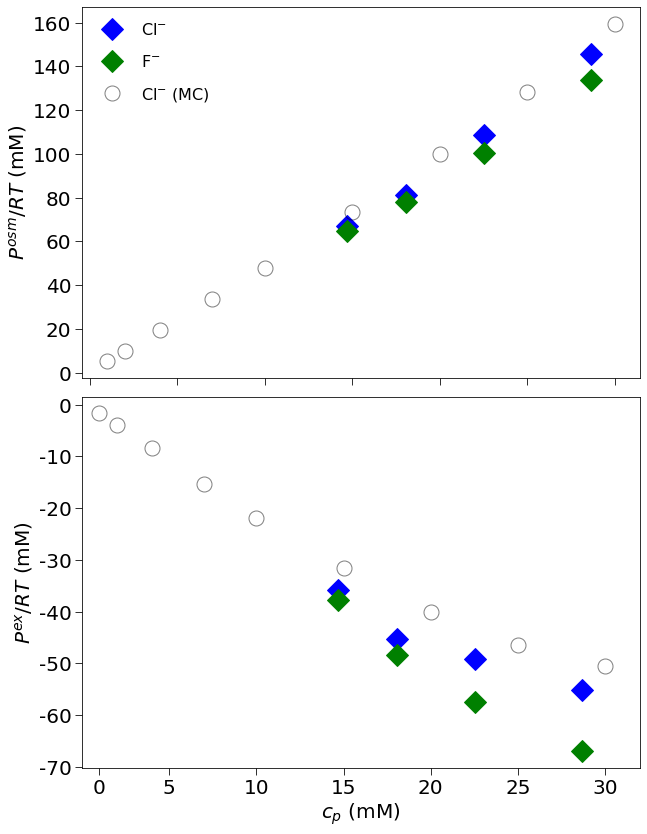

In [20]:
f = plt.figure(figsize=(10,14))
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.05)
ax1 = f.add_subplot(211)
######################################################################################
markersize = 15
fontsize = 20


# MD
ax1.plot(Cp_list/1000, p_osm_virtual_cell['Cl']/1000, 'bD', label='Cl$^{-}$', markersize=markersize)
ax1.plot(Cp_list/1000, p_osm_virtual_cell['F']/1000, 'gD', label='F$^{-}$', markersize=markersize)
ax1.set_ylabel('$P^{osm}/RT$ (mM)', fontsize=fontsize)       

# MC
ax1.plot(Cp_range, p_osm_cell['pH2'], 'k', marker='o',  markersize=markersize, linestyle=' ',markerfacecolor="None", alpha=.5, label='Cl$^{-}$ (MC)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1, yticks=[0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16], yticklabels=['0', '20', '40', '60', '80', '100', '120', '140', '160'] ) 

plt.legend(loc=2, frameon=0)


ax2 = f.add_subplot(212)
ax2.plot(Cp_range, p_osm_cell_ex['pH2'], 'k', marker='o',  markersize=markersize, markerfacecolor="None", linestyle=' ', alpha=.5)

ax2.plot(Cp_list/1000, p_osm_virtual_cell_excess['Cl']/1000, 'bD', label='Cl$^{-}$', markersize=markersize)
ax2.plot(Cp_list/1000, p_osm_virtual_cell_excess['F']/1000, 'gD', label='F$^{-}$', markersize=markersize)



plt.setp(ax2, xticks=[0.001, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030], xticklabels=['0', '5', '10', '15', '20', '25', '30'] ) 
plt.setp(ax2, yticks=[0, -0.01, -0.02, -0.03, -0.04, -0.05, -0.06, -0.07], yticklabels=['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'] ) 
ax2.set_xlabel('$c_p$ (mM)', fontsize=fontsize)
ax2.set_ylabel('$P^{ex}/RT$ (mM)', fontsize=fontsize) 
ax2.set_xlim(0, 0.032)
ax1.tick_params(labelsize=fontsize)
ax2.tick_params(labelsize=fontsize)

plt.savefig('MD_vs_MC_pressure.png', dpi= 300, bbox_inches='tight')